# Dependancies

## Requirements

In [1]:
#!pip install sentence_transformers langchain openai tqdm datasets asyncio scikit-learn cohere tiktoken umap altair

In [2]:
import numpy as np
import re
import pandas as pd
from tqdm.notebook import tqdm
from datasets import load_dataset
import umap
from time import sleep
import altair as alt
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from typing import List, Optional
import enum

from langchain_community.llms import Ollama
from langchain.output_parsers.regex_dict import RegexDictParser
from langchain.output_parsers import PydanticOutputParser
from langchain_core.messages import HumanMessage, SystemMessage, ChatMessage
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from pydantic import BaseModel, Field, validator, create_model
from openai import AsyncOpenAI, OpenAI
#import asyncio
import os
from typing import Tuple, List, Optional

import requests

from pydantic import BaseModel, ValidationInfo, model_validator

import json

import itertools
from copy import deepcopy
from tqdm.notebook import tqdm, trange
from sklearn.cluster import KMeans

import umap.umap_ as umap
#import umap
import hdbscan

In [3]:
from src.bubble import *
from src.models import *
from src.utilities import *

Retrieved company Darty : 1707313014508x102198350946437700
Retrieved project Expérience utilisateur de Darty : 1710335239022x546888753774592000


In [4]:
prompts_path = "Prompts/fr/"

## Bubble API

In [5]:
feedbacks_df = get("Feedback", max_objects=None)

In [6]:
categories_df = get("Category")
original_subcategories_df = get("SubCategory")


In [7]:
categories_df

,Company,Name,Project,_id
0,1707313014508x102198350946437700,Qualité du produit,1710335239022x546888753774592000,1710350409745x445953751757016450
1,1707313014508x102198350946437700,Service client,1710335239022x546888753774592000,1710350412899x638565534548052100
2,1707313014508x102198350946437700,Expérience d'achat,1710335239022x546888753774592000,1710350416439x770681541783434100
3,1707313014508x102198350946437700,Livraison et installation,1710335239022x546888753774592000,1710350419545x536227079121094340
4,1707313014508x102198350946437700,Service après-vente,1710335239022x546888753774592000,1710350422859x678271645638851300
5,1707313014508x102198350946437700,Programmes et offres,1710335239022x546888753774592000,1710350426602x488976415178478340
6,1707313014508x102198350946437700,NaN,1710335239022x546888753774592000,1710350430346x397407027406463360


In [8]:
ID_CATEG_NONE = categories_df[categories_df["Name"].isna()].iloc[0]["_id"]

In [9]:
company_infos = bubble_client.get(
    "Company",
    bubble_id=COMPANY_ID,
)
project_infos = bubble_client.get(
    "Project",
    bubble_id=PROJECT_ID,
)

In [10]:
categories_df

,Company,Name,Project,_id
0,1707313014508x102198350946437700,Qualité du produit,1710335239022x546888753774592000,1710350409745x445953751757016450
1,1707313014508x102198350946437700,Service client,1710335239022x546888753774592000,1710350412899x638565534548052100
2,1707313014508x102198350946437700,Expérience d'achat,1710335239022x546888753774592000,1710350416439x770681541783434100
3,1707313014508x102198350946437700,Livraison et installation,1710335239022x546888753774592000,1710350419545x536227079121094340
4,1707313014508x102198350946437700,Service après-vente,1710335239022x546888753774592000,1710350422859x678271645638851300
5,1707313014508x102198350946437700,Programmes et offres,1710335239022x546888753774592000,1710350426602x488976415178478340
6,1707313014508x102198350946437700,NaN,1710335239022x546888753774592000,1710350430346x397407027406463360


In [11]:
CategoryInsight = enum.Enum("Categories de l'insight", [(convert_text_to_constants(x), x) for x in list(categories_df[categories_df["Name"].notna()].Name)])

dict_SubCategoriesInsight = {}
for _,row in categories_df[categories_df["Name"].notna()].iterrows():
    concerned_subcat_df = original_subcategories_df[original_subcategories_df["Category"] == row["_id"]]
    concerned_subcat_df = concerned_subcat_df[concerned_subcat_df["Name"].notna()]
    row["Name"] = enum.Enum("Categories de l'insight", [(convert_text_to_constants(x), x) for x in concerned_subcat_df.Name])


In [12]:
df  = categories_df.copy()
df['Category'] = df['_id'].astype(str)
original_subcategories_df['Category'] = original_subcategories_df['Category'].astype(str)
df = pd.merge(original_subcategories_df, df, on=["Category", "Company"])
df = df[["Name_x", "Name_y", "Company", "_id_x", "_id_y"]]
df.columns = ["Name", "Category",  "Company", "_id", "Category_id"]
subcategories_df = df[df["Name"].notna()].reset_index(drop=True)
subcategories_df.head()

,Name,Category,Company,_id,Category_id
0,Fonctionnalité,Qualité du produit,1707313014508x102198350946437700,1710350410151x820615919729764900,1710350409745x445953751757016450
1,Durabilité,Qualité du produit,1707313014508x102198350946437700,1710350410504x667859650200292500,1710350409745x445953751757016450
2,Conformité,Qualité du produit,1707313014508x102198350946437700,1710350411096x295295631386005300,1710350409745x445953751757016450
3,Performance,Qualité du produit,1707313014508x102198350946437700,1710350411420x525018832955180160,1710350409745x445953751757016450
4,Design,Qualité du produit,1707313014508x102198350946437700,1710350411818x301326900426685440,1710350409745x445953751757016450


In [13]:
types_descr = columns_to_string(subcategories_df[subcategories_df["Name"].notna()], "Category", "Name")
print(types_descr)


Qualité du produit : Fonctionnalité
Qualité du produit : Durabilité
Qualité du produit : Conformité
Qualité du produit : Performance
Qualité du produit : Design
Qualité du produit : Rapport qualité-prix
Service client : Amabilité
Service client : Efficacité
Service client : Disponibilité
Service client : Compétence
Service client : Réactivité
Service client : Communication
Expérience d'achat : Navigation sur le site
Expérience d'achat : Conseil en magasin
Expérience d'achat : Processus de commande
Expérience d'achat : Options de livraison
Expérience d'achat : Facilité de retour
Expérience d'achat : Clarté des informations
Livraison et installation : Rapidité
Livraison et installation : Fiabilité
Livraison et installation : Professionnalisme des livreurs
Livraison et installation : Qualité de l'installation
Livraison et installation : Respect du créneau horaire
Livraison et installation : Conditionnement du produit
Service après-vente : Gestion des réclamations
Service après-vente : Dél

In [14]:
#example_insight = "Manque de clarté de l'affichage des prix en magasin"
#exemple_commentaire = "je suis exclusif metro je n ai aucun representant j achetais jusqu a present tout metro par facilite mais je suis tres souvent décue par la reponse ha non on n en a pas cela arrive demain je pense que depuis le covid tout le monde ou presque s en fou!!!"
#examples_insights_df = pd.DataFrame([
#    {"Insights qui devraient en découler": "Déceptions face aux retards de livraison"},
#    {"Insights qui devraient en découler": "Impression d'une baisse de qualité du service depuis le Covid"},
#])


feedback_context = {
    "entreprise": company_infos["Name"],
    "context": company_infos['Context'],
    "role": company_infos['Role'],
    "cible": project_infos['Target'],
    "insight_types": types_descr,
    #"insight_categories": tags_descr,
    #"question": project_infos['Study_question'],
    #"exemple_commentaire": exemple_commentaire,
    #"example_insights": '\n- '.join(list(examples_insights_df['Insights qui devraient en découler'])),
}

feedback_context

{'entreprise': 'Darty',
 'context': 'Fondée en 1957, Darty est une enseigne française spécialisée dans la distribution d\'électroménager, d\'équipements électroniques et de produits culturels. Rachetée par la Fnac en 2016, elle est aujourd\'hui l\'un des leaders européens de la distribution omnicanale.\n\nÉvènements récents:\n\n    2016: Rachat par la Fnac et création du groupe Fnac Darty.\n    2017: Lancement de la marketplace Darty.com.\n    2018: Déploiement du "Contrat de Confiance Fnac Darty" dans tous les magasins.\n    2019: Lancement de l\'offre de services "Darty+."\n    2020: Accélération de la transformation digitale du groupe.\n    2021: Acquisition de Mistergooddeal, spécialiste du e-commerce en produits reconditionnés.\n    2022: Lancement de la Fnac Darty Academy, une plateforme de formation en ligne.\n\nConcurrents:\n\n    Boulanger\n    Conforama\n    Gitem\n    Amazon\n    Cdiscount\n\nEnjeux:\n\n    Darty doit faire face à une concurrence accrue sur le marché de l\'é

# Insights extraction

### Aspects and Insights creation

In [15]:
class Aspect(BaseModel):
    categorie_id : int = Field(description="Indice de la catégorie concernée.")
    commentaire_id : int = Field(description="Indice du commentaire concernée.")
    note_satisfaction : int = Field(description="Note de satisfaction du client concernant cette sous-catégorie, de 1 (pas content) à 5 (très content).")
    explication: Optional[str] = Field(description="Eventuelle explication qui permetterait d'améliorer l'experience client, les produits ou la stratégie de l'entreprise. Ne doit être ajouté que ni réellement intéressant, et doit alors être aussi claire et concise que possible.") #Field(description="Point intéressant a retenir du commentaire.")
    
    @model_validator(mode="after")
    def validate_ids(self, info: ValidationInfo):
        assert (0 <= self.note_satisfaction) and (self.note_satisfaction <= 5)
        return self

class ListAspects(BaseModel):
    list_aspects:  List[Aspect] = Field(description="Liste des différents aspects évoqués.")
    
print(ListAspects(list_aspects=[Aspect(categorie_id=3, commentaire_id=42, note_satisfaction=5, explication=''), Aspect(categorie_id=9, commentaire_id=42, note_satisfaction=1, explication='Un colis de valeur a été abandonné devant la porte du client sans précaution')])
)

list_aspects=[Aspect(categorie_id=3, commentaire_id=42, note_satisfaction=5, explication=''), Aspect(categorie_id=9, commentaire_id=42, note_satisfaction=1, explication='Un colis de valeur a été abandonné devant la porte du client sans précaution')]


In [16]:
with open(prompts_path+'prompt_example.txt') as f:
    prompt_example = PromptTemplate.from_template(f.read())

exemple_unformatted = """
42: "le téléviseur que j'ai acheté est super cool, et répond parfaitement a mes attentes, mais la livraison était catastrophique… Ils ont laissés un ordi a 1500E devant ma porte!"

list_aspects:
    sous_categorie_id: 3
    commentaire_id: 42
    note_satisfaction: 5
    explication: ""

    sous_categorie_id: 9
    commentaire_id: 42
    note_satisfaction: 1
    explication: "Un colis de valeur a été abandonné devant la porte du client sans précaution"
"""
example_formatted = apply_async_analysis([prompt_example.invoke({"example": exemple_unformatted})], ListAspects)[0]


example_formatted

ListAspects(list_aspects=[Aspect(categorie_id=3, commentaire_id=42, note_satisfaction=5, explication=None), Aspect(categorie_id=9, commentaire_id=42, note_satisfaction=1, explication='Un colis de valeur a été abandonné devant la porte du client sans précaution')])

In [17]:
feedbacks_df

,Company,Content,Date,Project,Location,Sentiment,Source,Aspects,_id
0,1707313014508x102198350946437700,Achat Magic Keyboard avec Touch ID et pave num...,2024-02-07 00:00:00+00:00,1710335239022x546888753774592000,FR,5,Trustpilot,[],1710335410193x146397114086602720
1,1707313014508x102198350946437700,Très très apprécié d’installer la…\nTrès très ...,2024-01-31 00:00:00+00:00,1710335239022x546888753774592000,FR,5,Trustpilot,NaN,1710335410195x175970366374120320
2,1707313014508x102198350946437700,Machine à laver Bosch\nCommandée sur le site d...,2024-01-05 00:00:00+00:00,1710335239022x546888753774592000,FR,5,Trustpilot,NaN,1710335410202x536776314861663740
3,1707313014508x102198350946437700,VENTE FORCEE ?\nLe 8 nov 2023 j'achète un ordi...,2023-11-08 00:00:00+00:00,1710335239022x546888753774592000,FR,1,Trustpilot,NaN,1710335410203x151859605597644900
4,1707313014508x102198350946437700,Fausse vente de crédit gratuit\nFausse vente d...,2023-10-06 00:00:00+00:00,1710335239022x546888753774592000,FR,1,Trustpilot,NaN,1710335410205x126748698162511440
...,...,...,...,...,...,...,...,...,...
8974,1707313014508x102198350946437700,Globalement bien\nBonne qualité des communicat...,2011-12-01 00:00:00+00:00,1710335239022x546888753774592000,FR,5,Trustpilot,NaN,1710335488654x498578120665668540
8975,1707313014508x102198350946437700,nouvel adherent\nje viens de souscrire aà l'of...,2011-09-15 00:00:00+00:00,1710335239022x546888753774592000,FR,5,Trustpilot,NaN,1710335488655x206660558179535330
8976,1707313014508x102198350946437700,Mamac\nservice SAV LUXEMBOURG archi nul total...,2011-09-04 00:00:00+00:00,1710335239022x546888753774592000,BE,1,Trustpilot,NaN,1710335488659x219695565294586020
8977,1707313014508x102198350946437700,Très bon\nJe suis toujours très satisfaite de ...,2011-06-05 00:00:00+00:00,1710335239022x546888753774592000,FR,5,Trustpilot,NaN,1710335488660x275405440463435620


In [18]:
with open(prompts_path+'prompt_aspects.txt') as f:
    prompt_aspects = PromptTemplate.from_template(f.read())

batch_size = 10
aspects = []
prompts = []
for batch_df in batchify(feedbacks_df, batch_size):

    subcategories = "\n".join([f"{i} : '"+row["Category"]+" : "+row["Name"]+"'" for i, row in subcategories_df.iterrows()])
    batch_feedbacks = "\n\n".join([f"{i} : '"+row["Content"]+"'" for i, row in batch_df.iterrows()])

    prompts.append(prompt_aspects.invoke({"feedbacks": batch_feedbacks, "subcategories": subcategories, "example": example_formatted.json(), **context}).text)

print(prompts[0])

INSTRUCTIONS
Tu souhaite analyser les commentaires client de l'entreprise Darty qui te seront donnés.
Pour cela, tu cas extraire les différents aspects de chacun des commentaires.

Un aspect d'un commentaire se traduit pas un niveau de satisfaction relativement à une sous-catégorie, et une éventuelle explication.
Un commentaire peut donc avoir de nombreux aspects, ou n'en avoir aucun. Regroupe tous les aspects des différents commentaires, en précisant bien les indices des commenraires et catégories concernés.

Pour tous les aspects de chacun des commentaires, renvoit bien:
- L'indice du commentaire (qui est un entier).
- L'indice de la sous-catégorie concernée (qui est un entier).
- Le niveau de satisfaction du client relativement à cette sous-catégorie avec une note de 1 à 5. 
- Si le client donne une explication intéressante de son niveau de satisfaction, et qu'il est intéressant de la faire remonter au sein de entreprise, ajoute la. 
Si il n'y a pas d'explication, ou que celle ci n'

In [19]:
batch_aspects = []
for batch_prompts in tqdm(batchify(prompts, 100)):

    batch_aspects += apply_async_analysis(batch_prompts, ListAspects)
    sleep(60)

  0%|          | 0/90 [00:00<?, ?it/s]

In [20]:
aspects = sum([aspect.list_aspects for aspect in batch_aspects], [])
len(aspects)

10260

In [21]:
for batch_aspect in tqdm(batchify(aspects, 1000)):
#for i, aspect in tqdm(aspects):
    feedbacks = [feedbacks_df.iloc[aspect.commentaire_id] for aspect in batch_aspect]
    results = bubble_client.create(
        "Aspect",
        [{
            "Company": COMPANY_ID,
            "Project": PROJECT_ID,
            "Category": subcategories_df.loc[int(aspect.categorie_id), "Category_id"],
            "Consequence": "",
            "Date": str(feedback["Date"]),
            "Explanation": aspect.explication,
            "Rating": aspect.note_satisfaction,
            "SubCategory": subcategories_df.loc[int(aspect.categorie_id), "_id"],
            "Associated_feedback": feedback["_id"],
            }  for (aspect, feedback) in zip(batch_aspect, feedbacks)]
        )

#bubble_client.update_object(bubble_type="Feedback", bubble_id=feedback["_id"], fields={"Aspects": [res['id'] for res in results]})


  0%|          | 0/11 [00:00<?, ?it/s]

### Prepared for visu

In [22]:
aspects_df = get("Aspect")
ID_CATEG_NONE = categories_df[categories_df["Name"].isna()].iloc[0]["_id"]


In [23]:
import pandas as pd

def global_stats_and_rating_counts(df, interval="M"):
    """
    Calculates various statistics (mean, max, count) and rating counts for each groupby variable
    and interval in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        interval (str, optional): The time interval for grouping. Defaults to "M".
        groupby (str, optional): The column to group by. Defaults to "Category".

    Returns:
        pd.DataFrame: The output DataFrame with additional columns for statistics and rating counts.
    """

    df["Date"] = pd.to_datetime(df["Date"])  # Ensure correct datetime format
    groups = df.groupby(df["Date"].dt.to_period(interval))

    # Calculate mean, max, and total count using agg
    statistics = groups.agg(
        mean_rating=("Rating", "mean"),
        max_rating=("Rating", "max"),
        min_rating=("Rating", "min"),
        median_rating=("Rating", "median"),
        q1_rating = ("Rating", lambda x: np.quantile(x, 0.25)),
        q3_rating = ("Rating", lambda x: np.quantile(x, 0.75)),
        count=("Rating", "count")
    ).reset_index()

    # Calculate rating counts using value_counts() within a loop
    rating_counts = []
    for name, group in groups:
        rating_counts.append(group["Rating"].value_counts().rename(name))

    # Combine rating counts into a single DataFrame
    rating_counts_df = pd.concat(rating_counts, axis=1).fillna(0)

    merged_df = pd.concat([statistics.set_index("Date"), rating_counts_df.T], axis=1)
    # Merge statistics and rating counts
    display_format = "%m/%d/%Y"

    merged_df = merged_df.rename_axis('Date').reset_index()

    merged_df["Date"] = merged_df["Date"].apply(lambda x:x.strftime(display_format))
    merged_df['Date'] = pd.to_datetime(merged_df["Date"])  # Ensure correct datetime format

    if interval == 'W':
        merged_df['Date'] = merged_df['Date'] - pd.to_timedelta(merged_df['Date'].dt.day_of_week, unit='d')
    elif interval == 'M':
        merged_df['Date'] = merged_df['Date'] - pd.to_timedelta(merged_df['Date'].dt.day-1, unit='d')
    elif interval == 'Y':
        merged_df['Date'] = merged_df['Date'] - pd.to_timedelta(merged_df['Date'].dt.day_of_year-1, unit='d')

    merged_df["Date"] = merged_df["Date"].apply(lambda x:x.strftime(display_format))
    #merged_df["Date"] = merged_df["Date"].apply(lambda x:x.to_timestamp(interval))
    merged_df["Period"] = interval
    merged_df["Category"] = ID_CATEG_NONE
    merged_df["SubCategory"] = None
    merged_df["Grouped by"] = None
    return merged_df

# Example usage
df = aspects_df  # Load your DataFrame
#statistics, rating_counts_df = group_stats_and_rating_counts(df)
statistics_and_counts = global_stats_and_rating_counts(df, interval="M")
statistics_and_counts #.head()

/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_80103/338103157.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby(df["Date"].dt.to_period(interval))


,Date,mean_rating,max_rating,min_rating,median_rating,q1_rating,q3_rating,count,1,5,2,3,4,Period,Category,SubCategory,Grouped by
0,10/01/2010,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,M,1710350430346x397407027406463360,None,None
1,09/01/2011,3.000000,5,1,3.0,2.0,4.0,2,1.0,1.0,0.0,0.0,0.0,M,1710350430346x397407027406463360,None,None
2,12/01/2011,3.000000,5,1,3.0,2.0,4.0,2,1.0,1.0,0.0,0.0,0.0,M,1710350430346x397407027406463360,None,None
3,01/01/2012,4.181818,5,1,5.0,4.0,5.0,11,1.0,8.0,1.0,1.0,0.0,M,1710350430346x397407027406463360,None,None
4,02/01/2012,3.909091,5,1,5.0,3.0,5.0,11,1.0,6.0,2.0,0.0,2.0,M,1710350430346x397407027406463360,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,10/01/2023,3.377593,5,1,5.0,1.0,5.0,241,80.0,123.0,13.0,7.0,18.0,M,1710350430346x397407027406463360,None,None
142,11/01/2023,3.372434,5,1,5.0,1.0,5.0,341,115.0,176.0,20.0,5.0,25.0,M,1710350430346x397407027406463360,None,None
143,12/01/2023,3.669789,5,1,5.0,1.0,5.0,427,119.0,259.0,13.0,17.0,19.0,M,1710350430346x397407027406463360,None,None
144,01/01/2024,3.284360,5,1,5.0,1.0,5.0,211,81.0,107.0,6.0,3.0,14.0,M,1710350430346x397407027406463360,None,None


In [24]:
import pandas as pd

def group_stats_and_rating_counts(df, interval="M", groupby="Category"):
    """
    Calculates various statistics (mean, max, count) and rating counts for each groupby variable
    and interval in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        interval (str, optional): The time interval for grouping. Defaults to "M".
        groupby (str, optional): The column to group by. Defaults to "Category".

    Returns:
        pd.DataFrame: The output DataFrame with additional columns for statistics and rating counts.
    """
    if groupby is None:
        return global_stats_and_rating_counts(df, interval=interval)

    df["Date"] = pd.to_datetime(df["Date"])  # Ensure correct datetime format
    added_columns = [groupby] if groupby is not None else []
    added_columns += ["Category"] if groupby=="SubCategory" else []
    groups = df.groupby([df["Date"].dt.to_period(interval)]+added_columns)

    # Calculate mean, max, and total count using agg
    statistics = groups.agg(
        mean_rating=("Rating", "mean"),
        max_rating=("Rating", "max"),
        min_rating=("Rating", "min"),
        median_rating=("Rating", "median"),
        q1_rating = ("Rating", lambda x: np.quantile(x, 0.25)),
        q3_rating = ("Rating", lambda x: np.quantile(x, 0.75)),
        count=("Rating", "count")
    ).reset_index()

    # Calculate rating counts using value_counts() within a loop
    rating_counts = []
    for name, group in groups:
        rating_counts.append(group["Rating"].value_counts().rename(name))

    # Combine rating counts into a single DataFrame
    rating_counts_df = pd.concat(rating_counts, axis=1).fillna(0)

    multi_index = ["Date"] + added_columns
    merged_df = pd.concat([statistics.set_index(multi_index), rating_counts_df.T], axis=1)
    # Merge statistics and rating counts
    #merged_df = pd.merge(statistics, rating_counts_df, on=[name[0], groupby])

    #display_format = "%Y"
    #display_format += "-%m" if interval != "Y" else ""
    #display_format += "-%d" if interval != "M" else ""
    display_format = "%m/%d/%Y"

    print(multi_index)
    merged_df = merged_df.reset_index(names=multi_index)

    merged_df["Date"] = merged_df["Date"].apply(lambda x:x.strftime(display_format))
    merged_df['Date'] = pd.to_datetime(merged_df["Date"])  # Ensure correct datetime format

    if interval == 'W':
        merged_df['Date'] = merged_df['Date'] - pd.to_timedelta(merged_df['Date'].dt.day_of_week, unit='d')
    elif interval == 'M':
        merged_df['Date'] = merged_df['Date'] - pd.to_timedelta(merged_df['Date'].dt.day-1, unit='d')
    elif interval == 'Y':
        merged_df['Date'] = merged_df['Date'] - pd.to_timedelta(merged_df['Date'].dt.day_of_year-1, unit='d')

    merged_df["Date"] = merged_df["Date"].apply(lambda x:x.strftime(display_format))
    #merged_df["Date"] = merged_df["Date"].apply(lambda x:x.to_timestamp(interval))
    merged_df["Period"] = interval
    merged_df["Grouped by"] = groupby
    if "SubCategory" not in merged_df:
        merged_df["SubCategory"] = None

    return merged_df

# Example usage
df = aspects_df  # Load your DataFrame
#statistics, rating_counts_df = group_stats_and_rating_counts(df)
statistics_and_counts = group_stats_and_rating_counts(df, interval="M", groupby="Category")
statistics_and_counts #.head()

/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_80103/3959238154.py:22: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby([df["Date"].dt.to_period(interval)]+added_columns)


['Date', 'Category']


,Date,Category,mean_rating,max_rating,min_rating,median_rating,q1_rating,q3_rating,count,1,5,2,3,4,Period,Grouped by,SubCategory
0,10/01/2010,1710350426602x488976415178478340,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,M,Category,None
1,09/01/2011,1710350422859x678271645638851300,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,M,Category,None
2,09/01/2011,1710350426602x488976415178478340,5.000000,5,5,5.0,5.0,5.0,1,0.0,1.0,0.0,0.0,0.0,M,Category,None
3,12/01/2011,1710350412899x638565534548052100,5.000000,5,5,5.0,5.0,5.0,1,0.0,1.0,0.0,0.0,0.0,M,Category,None
4,12/01/2011,1710350422859x678271645638851300,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,M,Category,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,02/01/2024,1710350412899x638565534548052100,5.000000,5,5,5.0,5.0,5.0,1,0.0,1.0,0.0,0.0,0.0,M,Category,None
707,02/01/2024,1710350416439x770681541783434100,3.666667,5,1,5.0,2.0,5.0,6,2.0,4.0,0.0,0.0,0.0,M,Category,None
708,02/01/2024,1710350419545x536227079121094340,1.000000,1,1,1.0,1.0,1.0,4,4.0,0.0,0.0,0.0,0.0,M,Category,None
709,02/01/2024,1710350422859x678271645638851300,1.000000,1,1,1.0,1.0,1.0,3,3.0,0.0,0.0,0.0,0.0,M,Category,None


In [25]:
def find_empty_subcat(cat_id):
    df = original_subcategories_df.copy()

    df = df[df["Category"]==cat_id]
    return df[df["Name"].isna()].iloc[0]["_id"]

#find_empty_subcat("1709253065849x444427432726514300")




In [31]:


all_statistics = []
for groupby in [None, "Category", "SubCategory"]:
  for interval in ["Y", "M", "W"]:
    statistics = group_stats_and_rating_counts(aspects_df, interval=interval, groupby=groupby)

    #if "Category" not in statistics:
    #   statistics["Category"] = ID_SUBCATEG_NONE

    #if "SubCategory" not in statistics:
    #   statistics["SubCategory"] = ID_SUBCATEG_NONE

    assert statistics["Category"].isna().sum() == 0
    
    #statistics["Category"] = statistics["Category"].fillna(ID_CATEG_NONE)

    
    #statistics["SubCategory"] = statistics["SubCategory"].fillna(ID_SUBCATEG_NONE)
    #
    # _aspects(statistics)
    all_statistics.append(statistics)
all_statistics_df = pd.concat(all_statistics).reset_index()
all_statistics_df

/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_80103/338103157.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby(df["Date"].dt.to_period(interval))
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_80103/338103157.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby(df["Date"].dt.to_period(interval))
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_80103/338103157.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby(df["Date"].dt.to_period(interval))
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_80103/3959238154.py:22: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby([df["Date"].dt.to_period(interval)]+added_columns)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_

['Date', 'Category']
['Date', 'Category']


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_80103/3959238154.py:22: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby([df["Date"].dt.to_period(interval)]+added_columns)


['Date', 'Category']
['Date', 'SubCategory', 'Category']


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_80103/3959238154.py:22: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby([df["Date"].dt.to_period(interval)]+added_columns)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_80103/3959238154.py:22: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby([df["Date"].dt.to_period(interval)]+added_columns)


['Date', 'SubCategory', 'Category']


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_80103/3959238154.py:22: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby([df["Date"].dt.to_period(interval)]+added_columns)


['Date', 'SubCategory', 'Category']


,index,Date,mean_rating,max_rating,min_rating,median_rating,q1_rating,q3_rating,count,1,5,2,4,3,Period,Category,SubCategory,Grouped by
0,0,01/01/2010,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,Y,1710350430346x397407027406463360,None,None
1,1,01/01/2011,3.000000,5,1,3.0,1.0,5.0,4,2.0,2.0,0.0,0.0,0.0,Y,1710350430346x397407027406463360,None,None
2,2,01/01/2012,4.409836,5,1,5.0,5.0,5.0,61,3.0,46.0,5.0,5.0,2.0,Y,1710350430346x397407027406463360,None,None
3,3,01/01/2013,4.040000,5,1,5.0,3.0,5.0,25,5.0,18.0,0.0,0.0,2.0,Y,1710350430346x397407027406463360,None,None
4,4,01/01/2014,1.816667,5,1,1.0,1.0,2.0,60,44.0,10.0,3.0,0.0,3.0,Y,1710350430346x397407027406463360,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12671,5780,02/05/2024,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,W,1710350419545x536227079121094340,1710350419870x657684400109240000,SubCategory
12672,5781,02/05/2024,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,W,1710350419545x536227079121094340,1710350420627x419262368242996350,SubCategory
12673,5782,02/05/2024,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,W,1710350419545x536227079121094340,1710350421642x605642443756494700,SubCategory
12674,5783,02/05/2024,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,W,1710350422859x678271645638851300,1710350423320x983809434424183200,SubCategory


In [32]:
all_statistics_df

,index,Date,mean_rating,max_rating,min_rating,median_rating,q1_rating,q3_rating,count,1,5,2,4,3,Period,Category,SubCategory,Grouped by
0,0,01/01/2010,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,Y,1710350430346x397407027406463360,None,None
1,1,01/01/2011,3.000000,5,1,3.0,1.0,5.0,4,2.0,2.0,0.0,0.0,0.0,Y,1710350430346x397407027406463360,None,None
2,2,01/01/2012,4.409836,5,1,5.0,5.0,5.0,61,3.0,46.0,5.0,5.0,2.0,Y,1710350430346x397407027406463360,None,None
3,3,01/01/2013,4.040000,5,1,5.0,3.0,5.0,25,5.0,18.0,0.0,0.0,2.0,Y,1710350430346x397407027406463360,None,None
4,4,01/01/2014,1.816667,5,1,1.0,1.0,2.0,60,44.0,10.0,3.0,0.0,3.0,Y,1710350430346x397407027406463360,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12671,5780,02/05/2024,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,W,1710350419545x536227079121094340,1710350419870x657684400109240000,SubCategory
12672,5781,02/05/2024,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,W,1710350419545x536227079121094340,1710350420627x419262368242996350,SubCategory
12673,5782,02/05/2024,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,W,1710350419545x536227079121094340,1710350421642x605642443756494700,SubCategory
12674,5783,02/05/2024,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,W,1710350422859x678271645638851300,1710350423320x983809434424183200,SubCategory


In [36]:
EMPTY_CAT = categories_df[categories_df["Name"].isna()].iloc[0]["_id"]

In [37]:
df = all_statistics_df.copy()
#df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", drop="True", inplace=True)
df = df[df["Category"]==EMPTY_CAT]

df = df[df["Period"]=='M']
df

,index,mean_rating,max_rating,min_rating,median_rating,q1_rating,q3_rating,count,1,5,2,4,3,Period,Category,SubCategory,Grouped by
Date,,,,,,,,,,,,,,,,,
10/01/2010,0,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,M,1710350430346x397407027406463360,None,None
09/01/2011,1,3.000000,5,1,3.0,2.0,4.0,2,1.0,1.0,0.0,0.0,0.0,M,1710350430346x397407027406463360,None,None
12/01/2011,2,3.000000,5,1,3.0,2.0,4.0,2,1.0,1.0,0.0,0.0,0.0,M,1710350430346x397407027406463360,None,None
01/01/2012,3,4.181818,5,1,5.0,4.0,5.0,11,1.0,8.0,1.0,0.0,1.0,M,1710350430346x397407027406463360,None,None
02/01/2012,4,3.909091,5,1,5.0,3.0,5.0,11,1.0,6.0,2.0,2.0,0.0,M,1710350430346x397407027406463360,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10/01/2023,141,3.377593,5,1,5.0,1.0,5.0,241,80.0,123.0,13.0,18.0,7.0,M,1710350430346x397407027406463360,None,None
11/01/2023,142,3.372434,5,1,5.0,1.0,5.0,341,115.0,176.0,20.0,25.0,5.0,M,1710350430346x397407027406463360,None,None
12/01/2023,143,3.669789,5,1,5.0,1.0,5.0,427,119.0,259.0,13.0,19.0,17.0,M,1710350430346x397407027406463360,None,None


<Axes: xlabel='Date'>

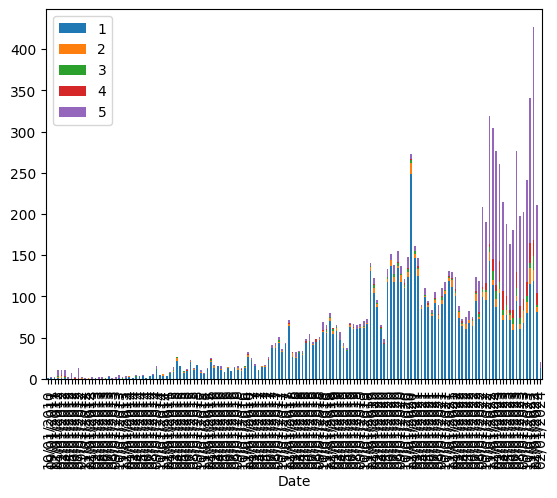

In [38]:

df = df[[1, 2, 3, 4, 5]]
df.plot(kind='bar', stacked=True)

In [ ]:
df = all_statistics_df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = df[df["Category"]!='1709322143530x849396050152903400']
df = df[df["SubCategory"].isna()]

df = df[df["Period"]=='M']
#df.set_index(["Date", "Category"], drop="True", inplace=True)
df.set_index("Date", drop="True", inplace=True)
df = df[["count", "Category"]]
df.head().to_csv("brouillon")

In [ ]:
categories_df

In [ ]:
[x for x in categories_df["_id"]]

In [ ]:
import matplotlib.pyplot as plt

# Reshape the data frame using pivot_table to prepare it for plotting
df_pivoted = df.pivot_table(index='Date', columns='Category', values='count', aggfunc='sum')

df_pivoted.columns = [categories_df[categories_df["_id"]==c].iloc[0]["Name"] for c in list(df_pivoted.columns)]

# Create the stacked bar plot using Matplotlib
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
df_pivoted.plot(kind='bar', stacked=True, colormap='Set2')

# Customize plot elements (optional):
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Stacked Bar Plot')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.legend(title='Category')
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
X = df["Date"].drop_duplicates()

In [ ]:


import matplotlib.pyplot as plt
import numpy as np

# data from https://allisonhorst.github.io/palmerpenguins/

species = (
    "Adelie\n $\\mu=$3700.66g",
    "Chinstrap\n $\\mu=$3733.09g",
    "Gentoo\n $\\mu=5076.02g$",
)
weight_counts = {
    "Below": np.array([70, 31, 58]),
    "Above": np.array([82, 37, 66]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Number of penguins with above average body mass")
ax.legend(loc="upper right")

plt.show()

In [ ]:
all_statistics_df[all_statistics_df["SubCategory"].isna()]

In [39]:
df = all_statistics_df.copy()
df = df[df["SubCategory"].isna()]
df["SubCategory"] = df["Category"].apply(find_empty_subcat)
res_df = all_statistics_df.copy()
res_df[res_df["SubCategory"].isna()] = df
all_statistics_df = res_df
all_statistics_df

,index,Date,mean_rating,max_rating,min_rating,median_rating,q1_rating,q3_rating,count,1,5,2,4,3,Period,Category,SubCategory,Grouped by
0,0,01/01/2010,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,Y,1710350430346x397407027406463360,1710350430693x925406702898368200,None
1,1,01/01/2011,3.000000,5,1,3.0,1.0,5.0,4,2.0,2.0,0.0,0.0,0.0,Y,1710350430346x397407027406463360,1710350430693x925406702898368200,None
2,2,01/01/2012,4.409836,5,1,5.0,5.0,5.0,61,3.0,46.0,5.0,5.0,2.0,Y,1710350430346x397407027406463360,1710350430693x925406702898368200,None
3,3,01/01/2013,4.040000,5,1,5.0,3.0,5.0,25,5.0,18.0,0.0,0.0,2.0,Y,1710350430346x397407027406463360,1710350430693x925406702898368200,None
4,4,01/01/2014,1.816667,5,1,1.0,1.0,2.0,60,44.0,10.0,3.0,0.0,3.0,Y,1710350430346x397407027406463360,1710350430693x925406702898368200,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12671,5780,02/05/2024,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,W,1710350419545x536227079121094340,1710350419870x657684400109240000,SubCategory
12672,5781,02/05/2024,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,W,1710350419545x536227079121094340,1710350420627x419262368242996350,SubCategory
12673,5782,02/05/2024,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,W,1710350419545x536227079121094340,1710350421642x605642443756494700,SubCategory
12674,5783,02/05/2024,1.000000,1,1,1.0,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,W,1710350422859x678271645638851300,1710350423320x983809434424183200,SubCategory


In [40]:
def send_aspects(df, batch_size=1000):
    d = {
        "Company": COMPANY_ID,
        "Project": PROJECT_ID,
        "Grouped by": row["Grouped by"],
        "Category": row['Category'],
        "SubCategory": row['SubCategory'],
        "Date": row["Date"],
        "Period": row["Period"],
        "Mean Rating": row["mean_rating"],
        "Min Rating": row["min_rating"],
        "Max Rating": row["max_rating"],
        "Q1 Rating": row["max_rating"],
        "Median Rating": row["max_rating"],
        "Q3 Rating": row["max_rating"],
        "Count": sum([row[i] for i in range(1,6)]),
        "Count of 1s": row[1],
        "Count of 2s": row[2],
        "Count of 3s": row[3],
        "Count of 4s": row[4],
        "Count of 5s": row[5],
        }  

    bubble_id = bubble_client.create("Aspect Evol",d)

send_aspects(all_statistics_df)

KeyError: 'Grouped by'